# Libraries

In [71]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

from sklearn.feature_selection import f_regression
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score


# Custom functions

In [2]:
#calculate adjusted r2
def m_adjusted_r2(obs_num, var_num,r2):
    return (1-(1-r2)*((obs_num-1)/(obs_num-var_num-1)))

#show features regression in Dataframe
def m_fregression(x,y):
    features_regression = pd.DataFrame(columns=['feature','coefficient','pval'])
    for i in range (x.shape[1]):
        df_f_regression = f_regression(x,y)
        row = {'feature':x.columns[i],'coefficient':df_f_regression[0][i].round(2),'pval':df_f_regression[1][i].round(5)}
        features_regression = features_regression.append(row,ignore_index=True)
    return (features_regression)

#calculating multicolinearity between variables
def m_VIF(x,y):
    #get columns names
    a = x.columns
    b = y.columns
    
    #loop to generate a (specially-formated) string containing (dependant variable) and (independent variables)
    string_fun = '{}~'.format(b[0])
    for i in range(0,len(a),1):
        string_fun = string_fun+"{}+".format(a[i])
        
    #to drop the last (+)
    string_fun= string_fun[0:len(string_fun)-1]
    string_fun
    
    #generate a full dataframe containing dependent and independent variables
    df_vif_gen = pd.merge(left=y,right=x,left_index=True,right_index=True)
    
    
    #find design matrix for regression model using 'rating' as response variable 
    y,x = dmatrices(string_fun, data=df_vif_gen, return_type='dataframe')

    #create DataFrame to hold VIF values
    vif_df = pd.DataFrame()
    vif_df['variable'] = x.columns 

    #calculate VIF for each predictor variable 
    vif_df['VIF'] = np.round([variance_inflation_factor(x.values, i) for i in range(x.shape[1])],2)

    #view VIF for each predictor variable 
    print ('VIF=1: There is no correlation between a given predictor variable and any other predictor variables in the model.\n')
    print ('VIF=(1-5): There is moderate correlation between a given predictor variable and other predictor variables in the model.\n')
    print ('VIF>5: There is severe correlation between a given predictor variable and other predictor variables in the model.')

    return vif_df

#reduce dataframe by quantile value (outlier), return the reduced dataframe and print the curve
def m_df_trim (dataframe,column_name,q_low,q_high):   
    q_low = dataframe[column_name].quantile(q=q_low)
    q_high = dataframe[column_name].quantile(q=q_high)

    df_reduced = dataframe[(dataframe[column_name]>q_low)&(dataframe[column_name]<=q_high)]
    print (np.round(100-df_reduced.shape[0]/dataframe.shape[0]*100,2),"% of data will be lost")
    fig, ax = plt.subplots(figsize=(15,5),nrows=1,ncols=2);
    sns.histplot(data=dataframe,x=column_name,ax=ax[0],label='Original');
    sns.histplot(data=df_reduced,x=column_name,ax=ax[1],label='Reduced')
    ax[0].legend()
    ax[1].legend()
    return df_reduced

#creating different linear regression models and a dataframe containing the summary info
def m_mlinear_regression(xtr,xts,ytr,yts):
#create a dataframe for modeling summary 
    models_summary = pd.DataFrame(columns=['Model','Type','Scaled','Score'])

    #multiple linear regression
    model = LinearRegression()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='Linear'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    
    #support vector regression
    model_variables=['rbf','linear','poly','sigmoid']
    for i in model_variables:
        model = SVR(kernel=i)
        model.fit(xtr,ytr)
        ypr = model.predict(xts)
        #
        model_name='SVR'
        model_type=i
        scaled='No'
        score = r2_score(yts,ypr)
        #plt.scatter(yts,ypr);
        #plt.plot(yts,ypr,color='r');
        models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #Decision treeregression
    model = DecisionTreeRegressor()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='Decision tree'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #Random forest regression
    model_variables = [100,200,300,400,500]
    for i in model_variables:
        model = RandomForestRegressor(n_estimators=i)
        model.fit(xtr,ytr)
        ypr = model.predict(xts)
        #
        model_name='Random forest'
        model_type=i
        scaled='No'
        score = r2_score(yts,ypr)
        #plt.scatter(yts,ypr);
        #plt.plot(yts,ypr,color='r');
        models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #XGBoost
    model = XGBRegressor()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='XGBoost'
    scaled='No'
    score = r2_score(yts,ypr)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    
#---------------SCALING-------------------#
    sc    = StandardScaler()              #
    xtr_sc= sc.fit_transform(xtr)         #
    xts_sc= sc.transform(xts)             #
#-----------------------------------------#
    #multiple linear regression
    model = LinearRegression()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='Linear'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    
    #support vector regression
    model_variables=['rbf','linear','poly','sigmoid']
    for i in model_variables:
        model = SVR(kernel=i)
        model.fit(xtr_sc,ytr)
        ypr = model.predict(xts_sc)
        #
        model_name='SVR'
        model_type=i
        scaled='Yes'
        score = r2_score(yts,ypr)
        #plt.scatter(yts,ypr);
        #plt.plot(yts,ypr,color='r');
        models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #Decision treeregression
    model = DecisionTreeRegressor()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='Decision tree'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #Random forest regression
    model_variables = [100,200,300,400,500]
    for i in model_variables:
        model = RandomForestRegressor(n_estimators=i)
        model.fit(xtr_sc,ytr)
        ypr = model.predict(xts_sc)
        #
        model_name='Random forest'
        model_type=i
        scaled='Yes'
        score = r2_score(yts,ypr)
        #plt.scatter(yts,ypr);
        #plt.plot(yts,ypr,color='r');
        models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #XGBoost
    model = XGBRegressor()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='XGBoost'
    scaled='Yes'
    score = r2_score(yts,ypr)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)


    model_summary = models_summary.sort_values(by='Score',ascending=False)
    model_summary.reset_index(inplace=True)
    return model_summary

# Importing data

In [3]:
df_rw = pd.read_csv('boston.csv')

**Input features in order:**
1) CRIM: per capita crime rate by town. <br>
2) ZN: proportion of residential land zoned for lots over 25,000 sq.ft.<br>
3) INDUS: proportion of non-retail business acres per town<br>
4) CHAS: Charles River dummy variable (1 if tract bounds river; 0 otherwise)<br>
5) NOX: nitric oxides concentration (parts per 10 million) [parts/10M]<br>
6) RM: average number of rooms per dwelling<br>
7) AGE: proportion of owner-occupied units built prior to 1940<br>
8) DIS: weighted distances to five Boston employment centres<br>
9) RAD: index of accessibility to radial highways<br>
10) TAX: full-value property-tax rate per $10,000 [$/10k]<br>
11) PTRATIO: pupil-teacher ratio by town<br>
12) B: The result of the equation B=1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town<br>
13) LSTAT: % lower status of the population<br>

**Output variable:**
1) MEDV: Median value of owner-occupied homes in $1000's [k$]

**Problem Description:**<br>
model the value of owner occupied homes related to different features.

# Exploring data

In [4]:
df_rw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


There are no null values, there are 13 columns (containing numbers)

In [5]:
df_rw.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.9,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.9,9.14,21.6


In [6]:
df_rw.describe(include='all')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [7]:
df = df_rw.copy()
col = df.columns.values

In [8]:
col

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'], dtype=object)

In [9]:
#changing the dependent variable column [MEDV] to be the first column
col = ['MEDV','CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT']
df = df[col]

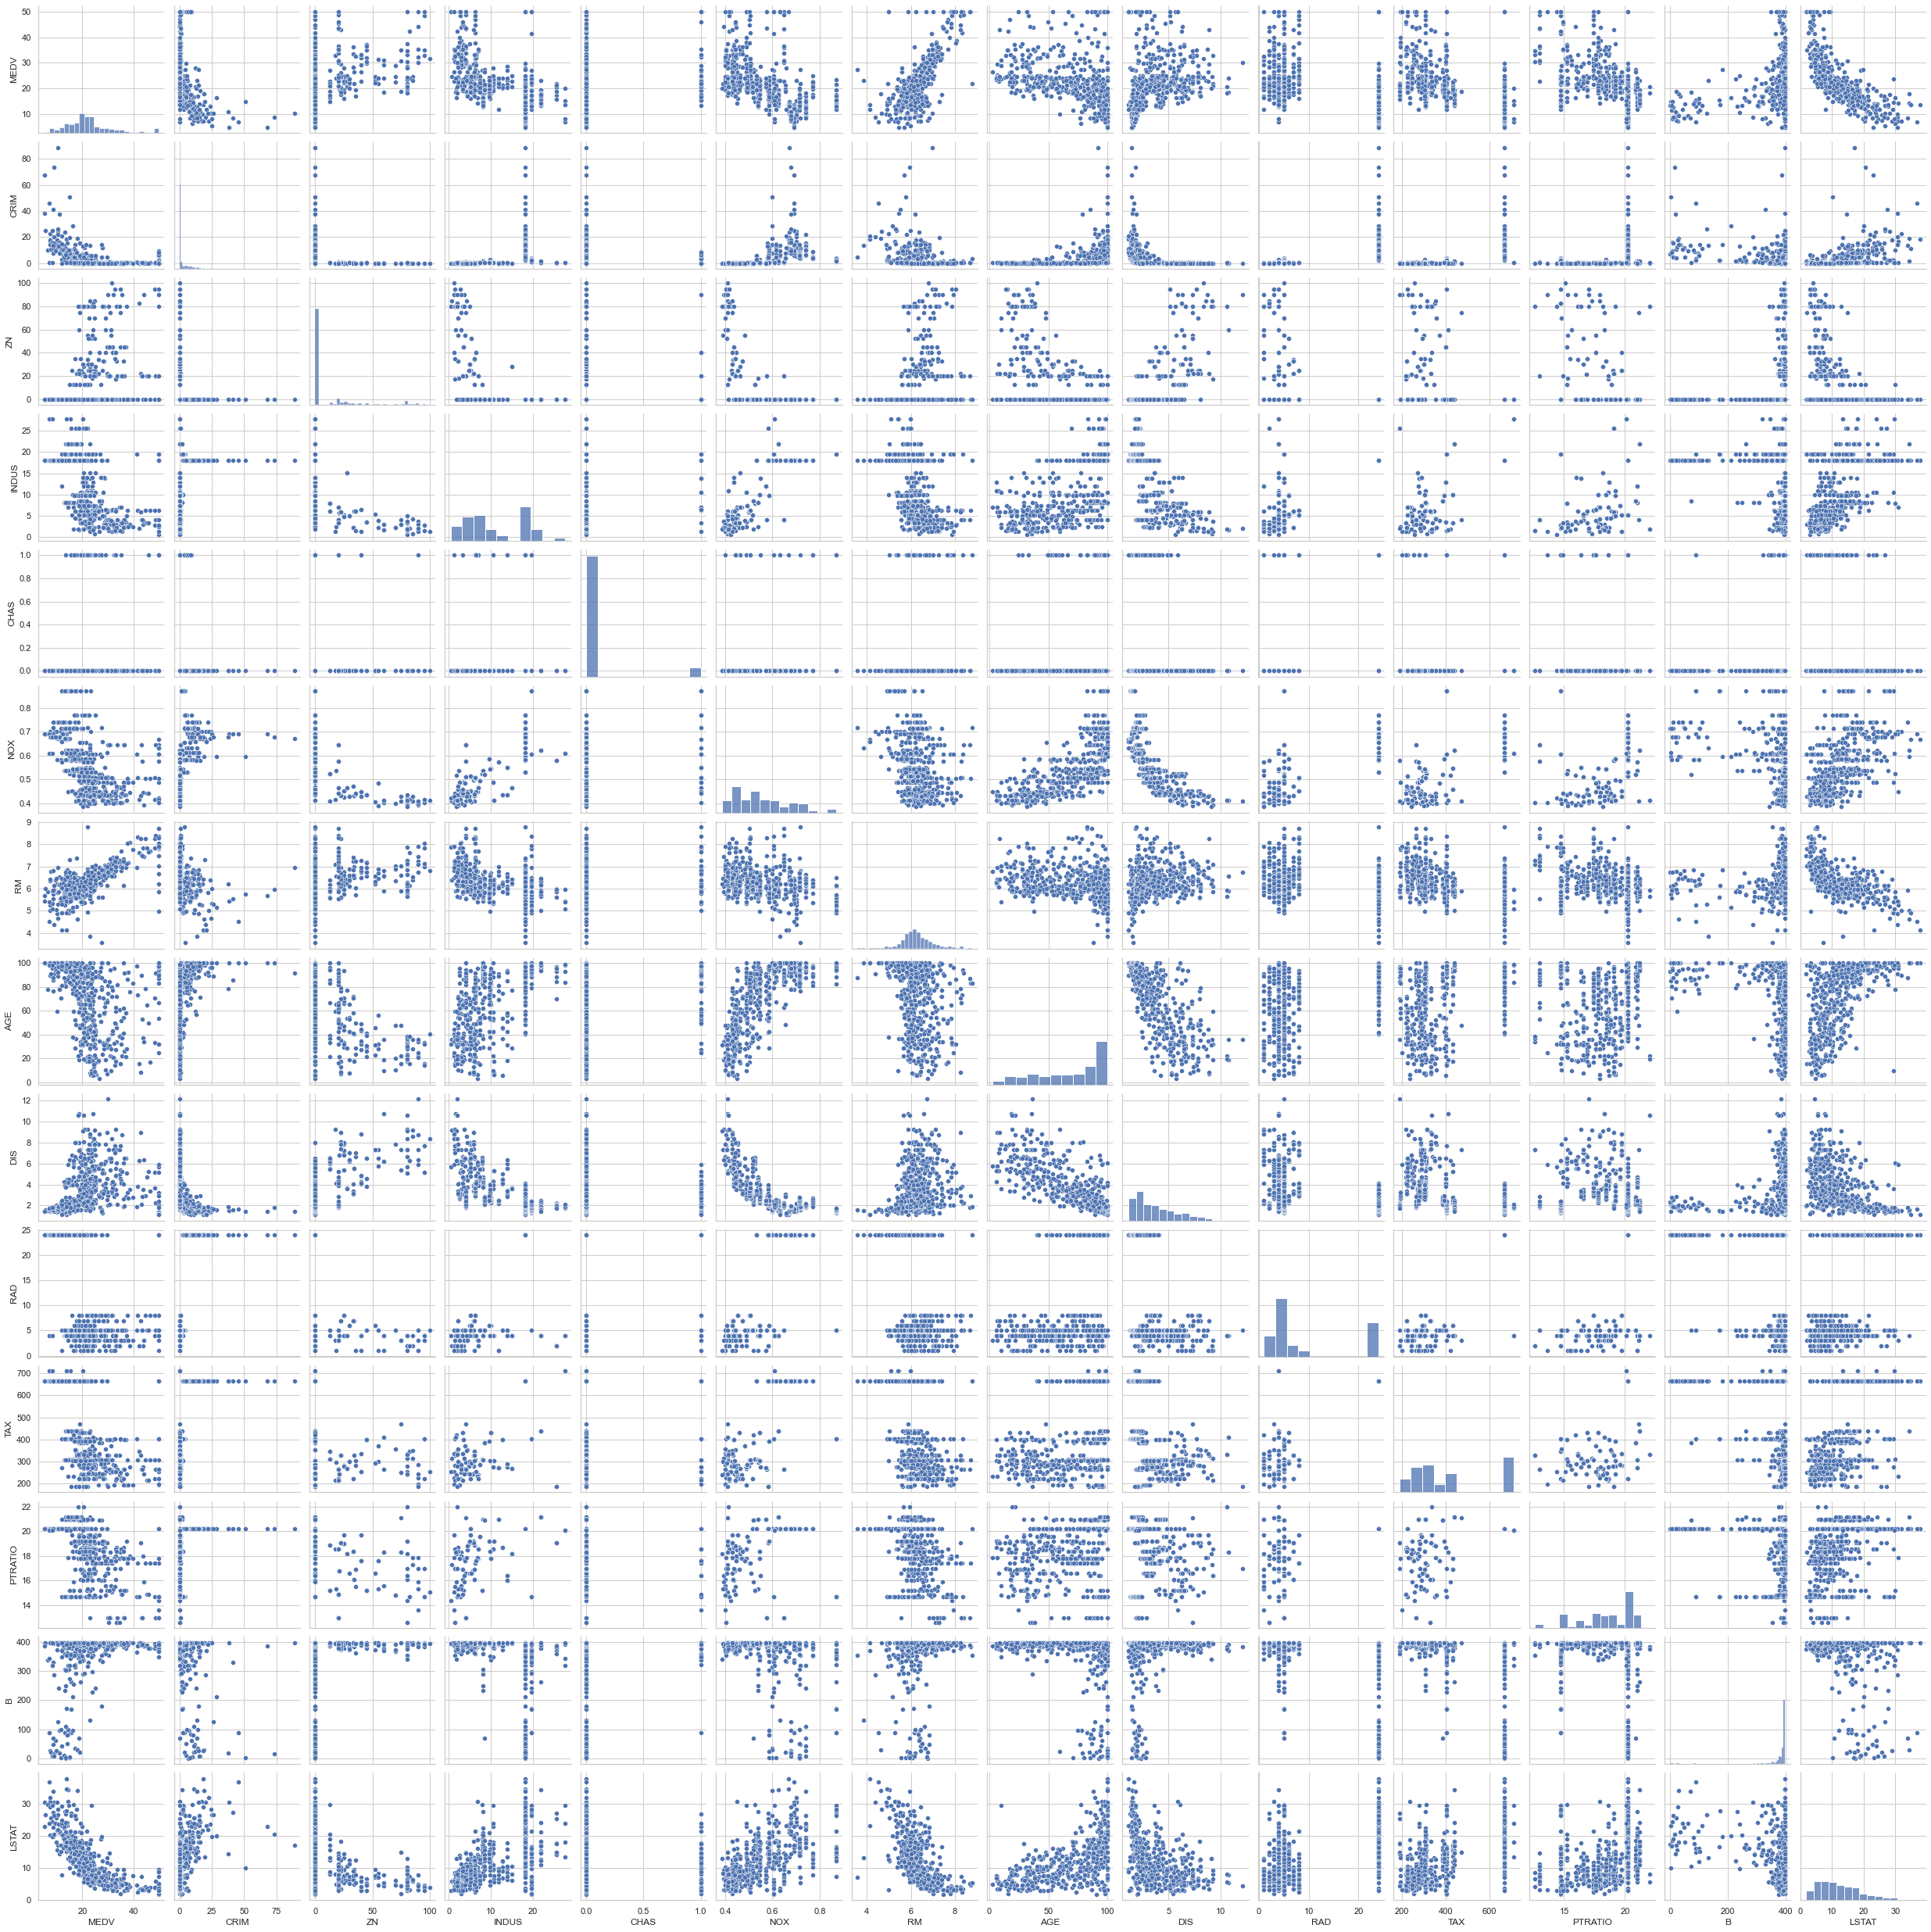

In [10]:
sns.pairplot(df);

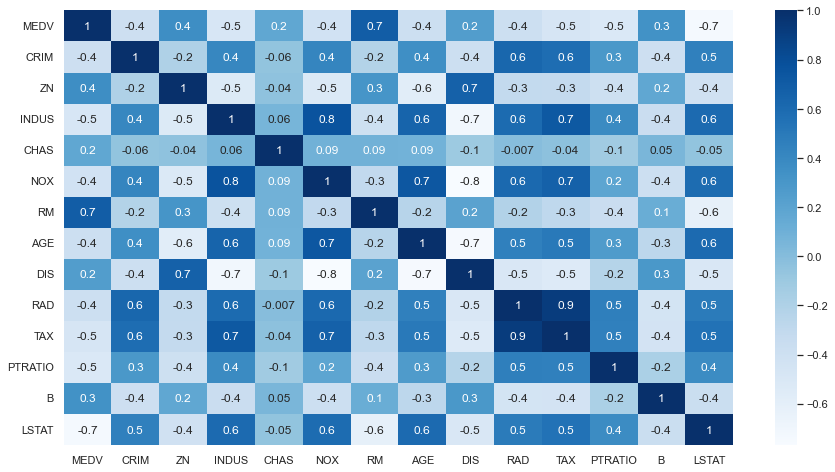

In [11]:
#let's check for correlation between all features
fig,ax = plt.subplots(figsize=(15,8))
sns.heatmap(df.corr(),cmap='Blues',annot=True,fmt='.1g',);

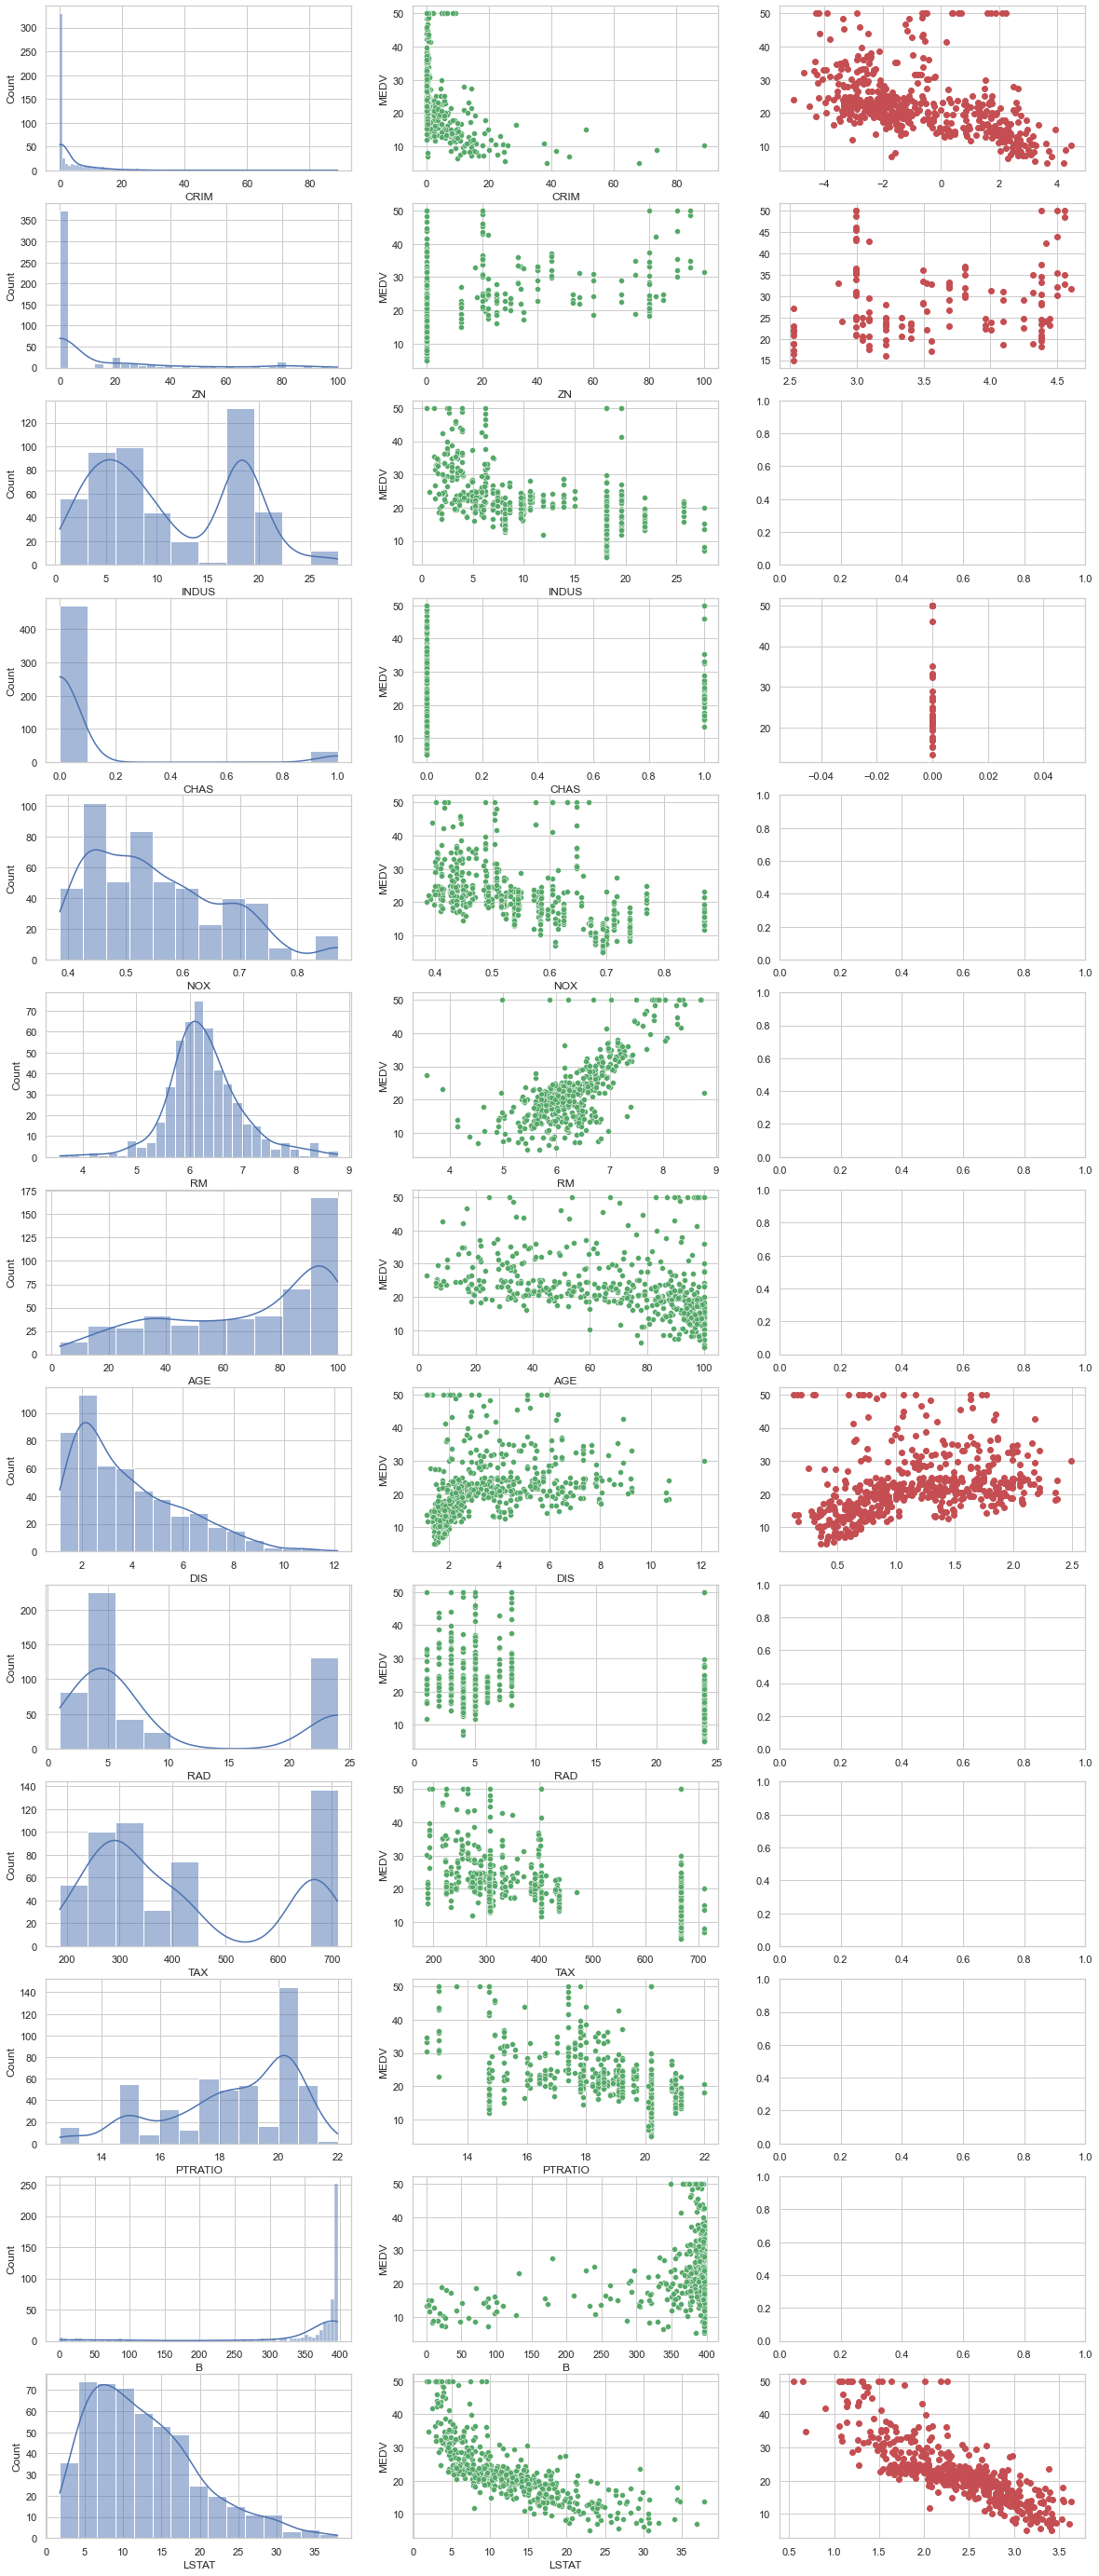

In [12]:
#visualizing and transforming features against dependent variable
fig,ax = plt.subplots(nrows=(len(col)-1),ncols=3,figsize=(20,50));
for i in range (1,len(col),1):
    sns.histplot(data=df.iloc[:,i],kde=True,ax=ax[i-1,0])
    sns.scatterplot(data=df,x=col[i],y=col[0],ax=ax[i-1,1],color='g');

#drawing the final features transformations
ax[0,2].scatter(np.log(df['CRIM']),df['MEDV'],color='r');
ax[1,2].scatter(np.log(df['ZN']),df['MEDV'],color='r');
ax[3,2].scatter(np.log(df['CHAS']),df['MEDV'],color='r');
ax[7,2].scatter(np.log(df['DIS']),df['MEDV'],color='r');
ax[12,2].scatter(np.log(df['LSTAT']),df['MEDV'],color='r');

**some elemantry insights:**
1) CRIM: skewed to right, there may be outliers <br>
2) ZN: skewed to right, there may be outliers<br>
3) CHAS: most of the unites are away from CHAS river<br>
4) NOX: little skewed to right, negative proportion to MEDV<br>
5) RM: uniformly distributed, it has positive proportion to MEDV<br>
6) AGE: skewed to left, it has almost constat value against MEDV<br>
7) DIS: skewed to right, it may has outliers<br>
8) RAD:<br>
9) TAX:<br> 
10) PTRATIO:<br>
11) B: is very skewed to right, it sure contains outliers<br>
12) LSTAT: may be skewed to right, and it has negative proportion to MEDV<br>

**Also,** <br>
CRIM: -ve corr with log<br>
IDUS: -ve corr<br>
CHAS: most of them are 0 <br>
NOX : -ve corr<br>
RM  : +ve corr<br>
DIS : +ve corr with log<br>
LSTAT: -ve corr with log<br>


# Data modelling

## Modelling full data
Before making any transformation or dopping data, i will try to run models on complete data and check the score of each model

In [13]:
Y = df[col[0:1]]
X = df[col[1:]]

In [14]:
m_fregression(X,Y)

,feature,coefficient,pval
0,CRIM,89.49,0.00000
1,ZN,75.26,0.00000
2,INDUS,153.95,0.00000
3,CHAS,15.97,0.00007
4,NOX,112.59,0.00000
5,RM,471.85,0.00000
6,AGE,83.48,0.00000
7,DIS,33.58,0.00000
8,RAD,85.91,0.00000
9,TAX,141.76,0.00000


In [15]:
#check for variance inflation factor
m_VIF(X,Y)

VIF=1: There is no correlation between a given predictor variable and any other predictor variables in the model.

VIF=(1-5): There is moderate correlation between a given predictor variable and other predictor variables in the model.

VIF>5: There is severe correlation between a given predictor variable and other predictor variables in the model.


,variable,VIF
0,Intercept,585.27
1,CRIM,1.79
2,ZN,2.30
3,INDUS,3.99
4,CHAS,1.07
5,NOX,4.39
6,RM,1.93
7,AGE,3.10
8,DIS,3.96
9,RAD,7.48


[RAD & TAX] columns have high VIF, so i guess they can be dropped from data to improve the model. But let's train the models on the raw data first

In [16]:
xtr,xts,ytr,yts = train_test_split(X,Y,train_size=0.9)
m_mlinear_regression(xtr,xts,ytr,yts)

,index,Model,Type,Scaled,Score
0,23,XGBoost,500,Yes,0.941765
1,11,XGBoost,500,No,0.941765
2,20,Random forest,300,Yes,0.925219
3,9,Random forest,400,No,0.921367
4,8,Random forest,300,No,0.920580
5,10,Random forest,500,No,0.920444
6,22,Random forest,500,Yes,0.919717
7,21,Random forest,400,Yes,0.919193
8,6,Random forest,100,No,0.919191
9,18,Random forest,100,Yes,0.918190


Only models (random forest & XGBoost) achieved score > 0.85, let's drop [TAX and RAD] columns and retrain the model

## Modelling (dropping some features)

In [17]:
# i will drop tax anad rad columns and re-evaluate the model
col_reduced  = list(col)
col_reduced.remove('TAX')
col_reduced.remove('RAD')

In [20]:
Y = df[col_reduced[0:1]]
X = df[col_reduced[1:]]

In [21]:
xtr,xts,ytr,yts = train_test_split(X,Y,train_size=0.9)
m_mlinear_regression(xtr,xts,ytr,yts)

,index,Model,Type,Scaled,Score
0,19,Random forest,200,Yes,0.896384
1,21,Random forest,400,Yes,0.893786
2,7,Random forest,200,No,0.892998
3,10,Random forest,500,No,0.891784
4,8,Random forest,300,No,0.891633
5,20,Random forest,300,Yes,0.891287
6,22,Random forest,500,Yes,0.890943
7,9,Random forest,400,No,0.890269
8,18,Random forest,100,Yes,0.889620
9,11,XGBoost,500,No,0.888399


WOW!, by dropping TAX & RAD our model has **performed better.** <br> 
let's try to make some log transformation to some features and check if they improve our model

## Modelling (transforming some features)

In [22]:
#i will add the transformed columns to dataframe
df['CRIM_log'] = np.log(df['CRIM'])
df['DIS_log'] = np.log(df['DIS'])
df['LSTAT_log'] = np.log(df['LSTAT'])

In [23]:
col_transformed = df.columns
col_transformed

Index(['MEDV', 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT', 'CRIM_log', 'DIS_log', 'LSTAT_log'],
      dtype='object')

In [24]:
df_transformed = df[['MEDV','ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
       'PTRATIO', 'B','CRIM_log', 'DIS_log', 'LSTAT_log']]

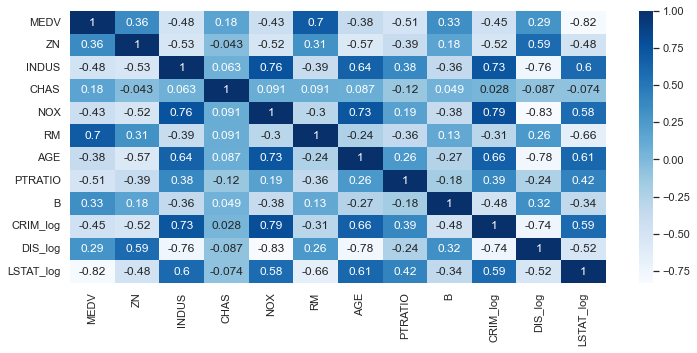

In [25]:
plt.figure(figsize=(12,5));
sns.heatmap(df_transformed.corr(),cmap='Blues',annot=True);

the correlation for [CRIM, DIS ,LSTAT] columns improved, **but not highly improved**

In [26]:
Y = df[df_transformed.columns[0:1]]
X = df[df_transformed.columns[1:]]

In [27]:
xtr,xts,ytr,yts = train_test_split(X,Y,train_size=0.9)
m_mlinear_regression(xtr,xts,ytr,yts)

,index,Model,Type,Scaled,Score
0,11,XGBoost,500,No,0.935962
1,23,XGBoost,500,Yes,0.935952
2,19,Random forest,200,Yes,0.932513
3,8,Random forest,300,No,0.932372
4,9,Random forest,400,No,0.931647
5,7,Random forest,200,No,0.931491
6,22,Random forest,500,Yes,0.930911
7,10,Random forest,500,No,0.930414
8,20,Random forest,300,Yes,0.930251
9,21,Random forest,400,Yes,0.930004


The score is slighlty improved but not very high

# Findings

1) Random forest and XGBoost modelling is the best for our data <br>
2) [TAX and RAD] columns are not good feauters for predicting our target <br>
3) It'd not give high advantage for our model result, if we transform [CRIM, DIS, LSTAT] features

# K fold

In [59]:
Y = df[col[0:1]]
X = df[col[1:]]
xtr,xts,ytr,yts = train_test_split(X,Y,train_size=0.9)

In [60]:
m_mlinear_regression(xtr,xts,ytr,yts)

,index,Model,Type,Scaled,Score
0,20,Random forest,300,Yes,0.938217
1,9,Random forest,400,No,0.937856
2,10,Random forest,500,No,0.936895
3,7,Random forest,200,No,0.936608
4,19,Random forest,200,Yes,0.935066
5,22,Random forest,500,Yes,0.934213
6,6,Random forest,100,No,0.934196
7,21,Random forest,400,Yes,0.933449
8,8,Random forest,300,No,0.932956
9,18,Random forest,100,Yes,0.924154


In [61]:
#scaling
sc = StandardScaler()
xtr_sc = sc.fit_transform(xtr)
xts_sc = sc.transform(xts)

In [62]:
#modeling
model_1 = XGBRegressor()
model_1.fit(xtr_sc,ytr)

model_2 = RandomForestRegressor(n_estimators=100)
model_2.fit(xtr_sc,ytr)

RandomForestRegressor()

In [63]:
#K fold
accuracies_1 = cross_val_score(estimator=model_1,X=xtr_sc,y=ytr,cv=10)
accuracies_2 = cross_val_score(estimator=model_2,X=xtr_sc,y=ytr,cv=10)

In [64]:
print(accuracies_1.mean())
print(accuracies_1.std())

0.8872872581771549
0.05763316879152415


In [65]:
print(accuracies_2.mean())
print(accuracies_2.std())

0.8665506506478898
0.10279028494323347


In [69]:
print(accuracies_1.max())
print(accuracies_2.max())

0.9458978471140463
0.9367799784630009


In [70]:
print (accuracies_1.min())
print (accuracies_2.min())

0.7361404974741301
0.5684730610087211


**XGBoost** is better model

# Grid search for XGBoost

In [75]:
ml = RandomForestRegressor()
ml.fit(xtr_sc,ytr)

RandomForestRegressor()

In [ ]:
parameters = [{'n_estimators':[100,200,300,400,500],'bootstrap':[True,False]}]
gsearch = GridSearchCV(estimator=ml,
                       param_grid=parameters,
                       scoring='accuracy',
                       cv=10)
gsearch.fit(xtr_sc,ytr)

In [ ]:
gsearch.best_score_

# Dimensionality reduction

## PCA

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
xtr_pca = pca.fit_transform(xtr)
xts_pca = pca.transform(xts)

In [27]:
m_mlinear_regression(xtr_pca,xts_pca,ytr,yts)

,index,Model,Type,Scaled,Score
0,9,Random forest,400,No,0.874231
1,7,Random forest,200,No,0.873879
2,10,Random forest,500,No,0.872014
3,8,Random forest,300,No,0.870178
4,6,Random forest,100,No,0.866552
5,2,SVR,linear,No,0.809940
6,0,Linear,General,No,0.801259
7,5,Decision tree,General,No,0.737197
8,1,SVR,rbf,No,0.032395
9,3,SVR,poly,No,-0.008309


our model didn't perform well after reducing dimensionality by PCA

## LDA

In [28]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
ldc = LinearDiscriminantAnalysis(n_components=2)
xtr_ldc= ldc.fit_transform(xtr,ytr)

ValueError: Unknown label type: (array([22.9,  7.4, 23.9, 22.9, 28.7, 24. , 33.1, 28.7, 21.2, 24.7, 33. ,
       20.1, 48.3, 23.7, 21. , 16.6, 18.7, 16.1, 28.7, 32.7, 20.7, 31.7,
       17.6, 50. , 25. , 15. , 23.9, 13.6, 23.7, 24.5, 50. , 25. , 20.4,
       13.1, 30.7, 35.1, 21.2, 13.6, 19.1, 20.7, 20. , 32.9,  9.5, 22.2,
       20.4, 17.2, 23.7, 16.2, 31. , 11.7, 50. , 20.9, 19.9, 23.8, 17.9,
       22.9, 13.3, 31.6,  7. , 20.1, 21.2, 50. , 22. , 28.2, 18.2, 23.1,
       18.2, 12.5, 21.4, 13.8, 20.1, 19.9, 22.6, 50. , 22.6, 20.1, 21.9,
       11.8, 10.5,  8.4, 30.5, 14.5, 11.9, 18.6, 50. , 10.9, 30.1, 16.1,
       22. , 18.8, 32. , 24.5, 10.5, 22.3, 23.8, 33.1, 17.8, 16.6,  9.6,
       24.8,  8.1, 30.1, 20.5, 50. ,  5.6, 30.1, 22. , 14.1, 10.4, 17.5,
        7. , 45.4, 22.9, 23. , 22.3, 21.7, 13.9, 25.3, 13.1, 16.3, 21.7,
       13.4,  5. , 28.1, 42.3, 18.3, 16.1, 26.7, 21.4, 22.2, 21.8, 23.1,
       24.2, 29.1, 41.3, 22. , 22.2, 16.7, 22.6, 13.5, 18.4, 12.7, 19.6,
       23. ,  7.5, 19.2, 14.9, 23.1, 18. , 16.5, 18.2, 21.4, 24.8, 29.6,
       24.4, 13.5, 43.5, 17.8, 17.5, 19.3, 22.7, 33.4, 13.1, 19.6, 28.6,
       13.9, 13.1, 19.4,  8.3, 24.5, 16.8, 28.4, 32.4, 21.7,  8.3, 20.6,
       20. , 19.8, 21.2, 20.8,  8.8, 24.1, 27.9, 38.7, 19.5, 14.3, 17.2,
       25. , 19.3, 15.7, 29.1, 12.3, 50. , 19.5, 20.8, 23.2, 24.8, 24.3,
       23.3, 22.2, 23.1, 22. , 50. , 15.4, 24.4, 13.8, 15. , 27.1,  8.8,
       36.2, 26.6, 44. , 14.6, 19.8, 21.9, 50. , 44.8, 14.1, 23.7, 21.5,
       15.2, 13.3, 22.4, 27.5, 19.3, 19.4, 18.7, 17.5, 23.9, 14.2, 29.6,
       17.4, 11.8, 18.5, 43.8, 29. , 12.1, 32.5, 19.4, 17.8, 20.6, 34.9,
       29.9, 29.8, 23.6, 13.3, 23. , 19.6, 23.1, 19. , 24.3, 24.4, 19.7,
       16.5, 11.5,  7.2, 12.8, 22.7, 29. , 19.1, 19.2, 50. ,  5. , 15.4,
       26.5, 12. , 14.6,  8.4, 22.5, 33.2, 18.5, 12.6, 14.3, 17.1, 23.9,
       17.4, 28. , 27.5, 14. , 19.4, 25.2, 50. ,  8.7, 19.6, 20. , 23.1,
       14.5, 13.8, 23.4, 27.9, 10.4, 48.5, 23.3, 20.3, 22. , 20. , 34.9,
       22.5, 16. , 24.3, 24.6, 10.2, 23.8, 14.4, 15.6, 19.9, 20.5, 17.3,
       20.3, 21.7, 21.7, 14.8, 21.9, 11.3, 10.8, 32.2, 24.6, 33.4, 26.6,
       12.7, 24.8, 35.4,  6.3, 33.3, 14.4, 25. , 23.2, 20.2, 32. , 22.8,
       10.2, 23.8, 48.8, 23.3, 36.1, 18.5, 11.9, 23.6, 43.1, 18.9, 21.8,
       25. , 21.7, 23.2, 37.9, 24.7, 21.1, 16.8,  9.7, 26.4, 29.8, 21.2,
       20.6, 28.4, 26.4, 14.9, 10.2, 37.2, 23.1, 22.8, 50. , 21.6, 27.5,
       33.2, 19.3, 25.1, 23.4, 37. , 19.1, 50. , 19.1, 23. , 19.6, 15.2,
       19.3, 11. , 20.2, 20.6, 13. , 22.6, 31.1, 20. , 25. , 19.9, 10.9,
       26.2, 18.3, 34.6, 22.8, 28.5, 21.4, 15. , 13.4, 15.3, 31.5, 29.4,
       27. , 22.6, 20.4, 13.4, 19.5, 13.2, 18.4, 19.4, 19.4, 23.3, 24.7,
       36.5, 24.1, 13.4, 18.6, 17.7, 30.3, 18.9, 31.2, 20.5, 14.1, 15.6,
       25. , 17.2, 22.2, 20.6, 15.6, 16.7, 21.5, 15.2, 23.2, 36.2, 15.6,
       20.3, 17. , 11.7, 31.5, 33.8, 19.7, 20.6, 22.4, 18.8,  8.5, 24.1,
       14.9, 12.7, 20.4, 20.8, 22.8, 23.5, 42.8, 24.4, 34.7, 20.1, 17.4,
        7.2, 17.8, 21.4, 13.8]),)

# Kernel PCA

In [63]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components=2,kernel='rbf')
xtr_k  = kpca.fit_transform(xtr)
xts_k = kpca.transform(xts)

In [64]:
m_mlinear_regression(xtr_k,xts_k,ytr,yts)

,index,Model,Type,Scaled,Score
0,0,Linear,General,No,0.024279
1,1,SVR,rbf,No,0.023759
2,4,SVR,sigmoid,No,0.008727
3,2,SVR,linear,No,0.007405
4,3,SVR,poly,No,-0.002797
5,7,Random forest,200,No,-0.331598
6,8,Random forest,300,No,-0.350542
7,6,Random forest,100,No,-0.365224
8,10,Random forest,500,No,-0.366940
9,9,Random forest,400,No,-0.380312


our model didn't perform well after reducing dimensionality by kernel PCA

# Clustering

In [26]:
from sklearn.cluster import KMeans

In [27]:
df_cluster = df_rw.copy()

In [28]:
col_cluster = df_cluster.columns
col_cluster

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

In [29]:
df_cluster = df_cluster[['MEDV','CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT']]

In [30]:
wcss=[]
n_cluster=[]

for i in range (1,10,1):
    kmeans=KMeans(n_clusters=i,init='k-means++')
    kmeans.fit(df_cluster)
    n_cluster.append(i)
    wcss.append(kmeans.inertia_)

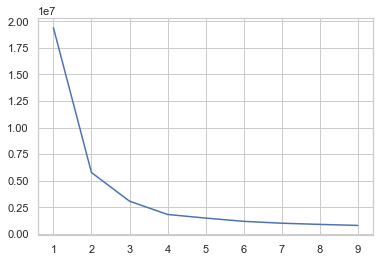

In [31]:
plt.plot(n_cluster,wcss);

WOW!, our data can be classified before performing any regression models

In [32]:
#modeling with 2 clusters
model_clusters = KMeans(n_clusters=2,init='k-means++')
ypr = model_clusters.fit_predict(df_cluster)
df_cluster['ypr'] = ypr

In [33]:
col = df_cluster.columns

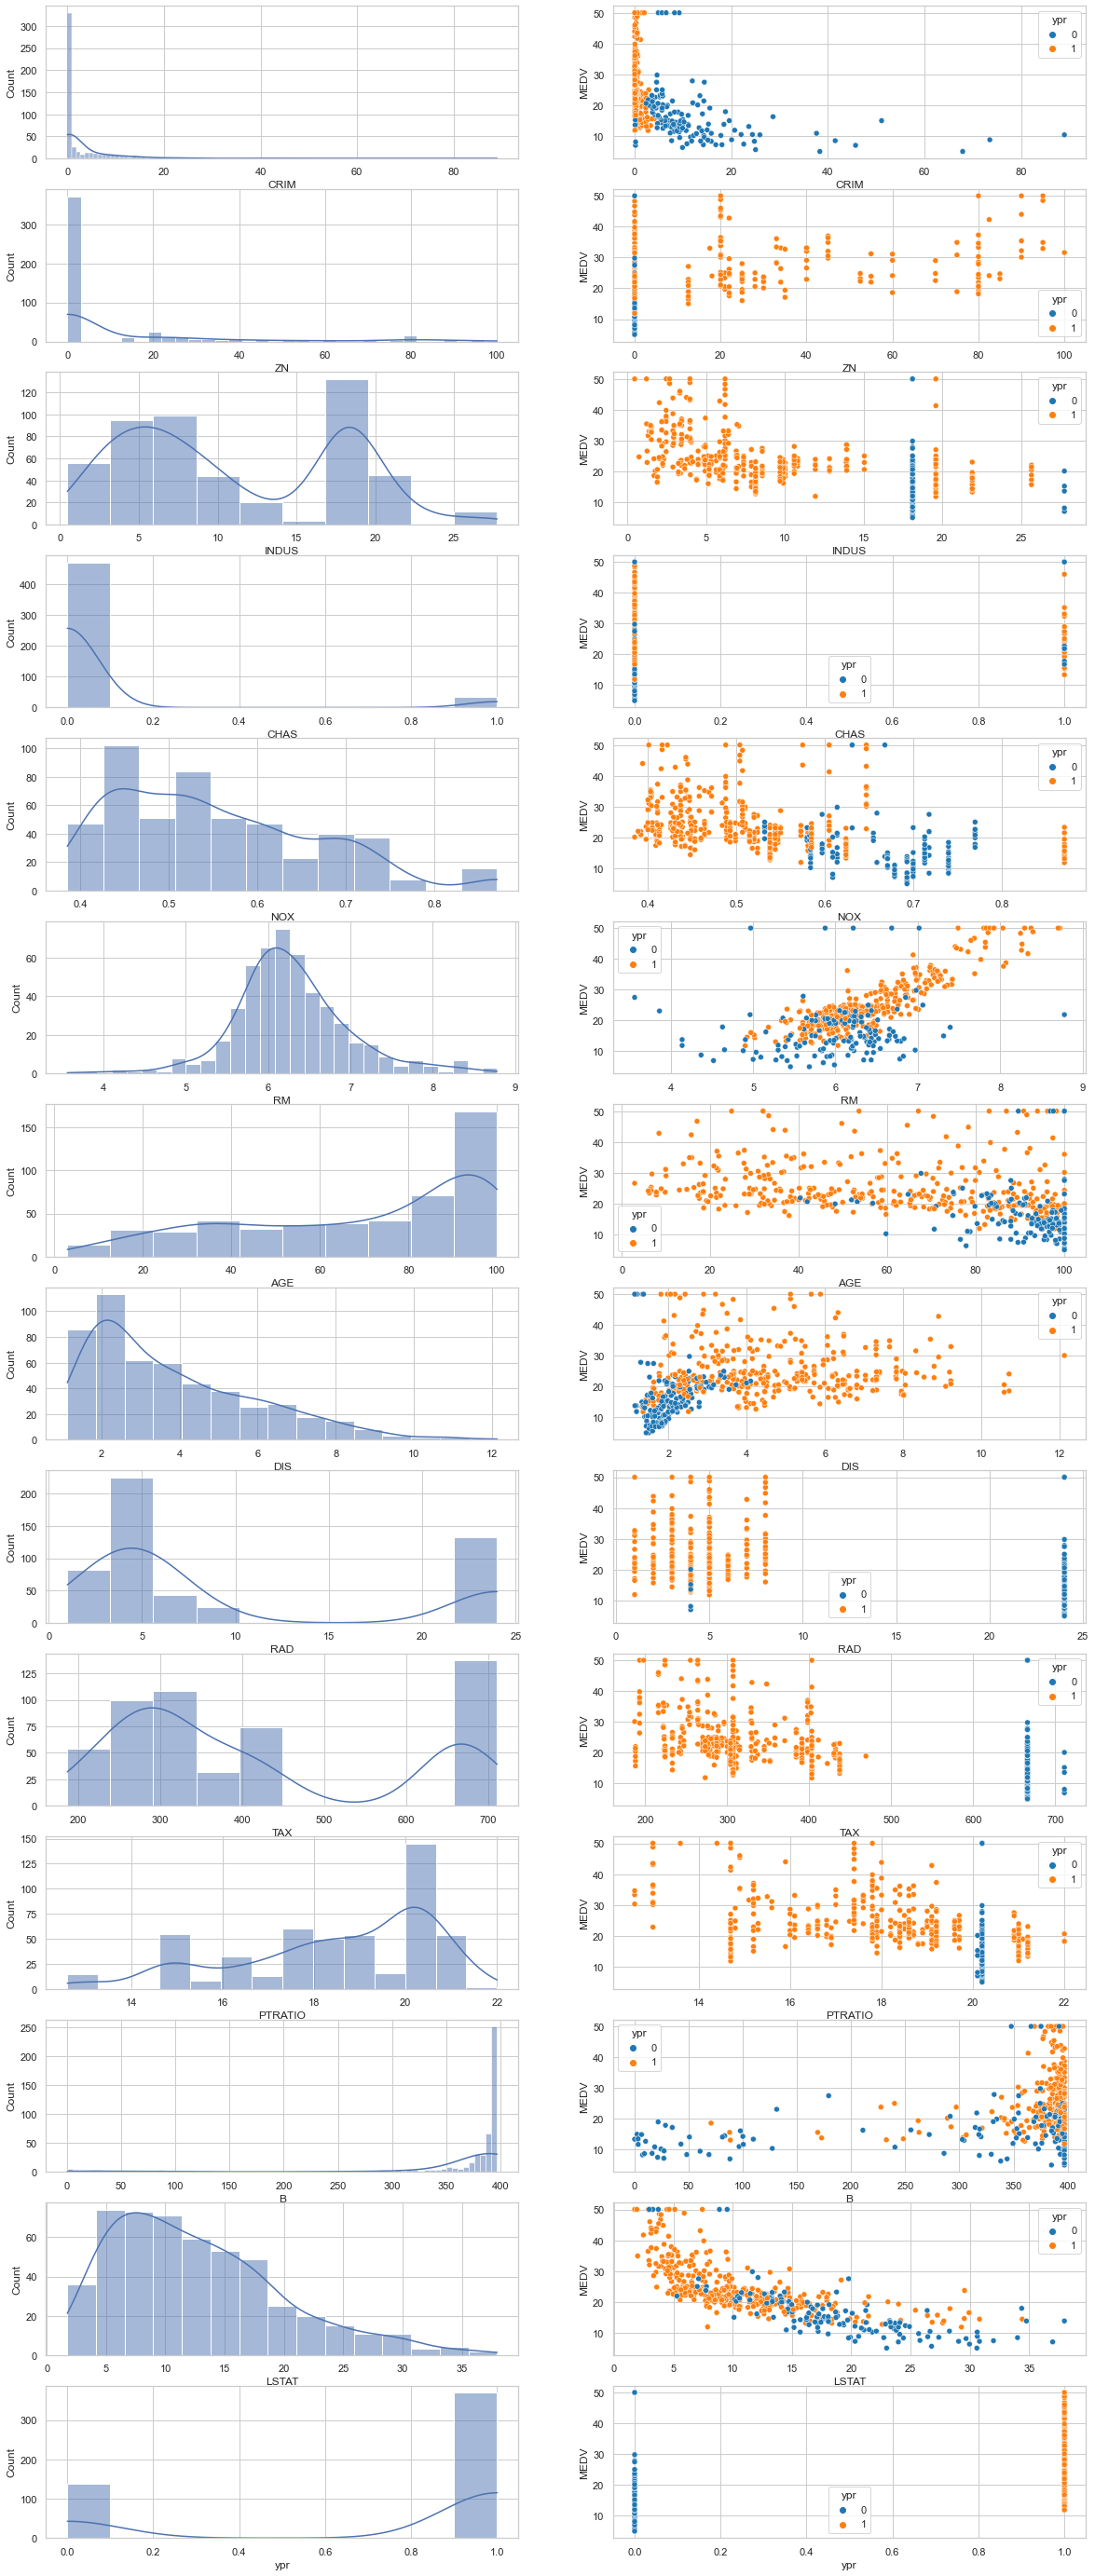

In [34]:
#visualizing and transforming features against dependent variable
fig,ax = plt.subplots(nrows=(len(col)-1),ncols=2,figsize=(20,50));
for i in range (1,len(col),1):
    sns.histplot(data=df_cluster.iloc[:,i],kde=True,ax=ax[i-1,0])
    sns.scatterplot(data=df_cluster,x=col[i],y=col[0],ax=ax[i-1,1],hue='ypr',palette='tab10');


In [35]:
#modeling with 4 clusters
model_clusters = KMeans(n_clusters=4,init='k-means++')
ypr = model_clusters.fit_predict(df_cluster)
df_cluster['ypr'] = ypr

In [36]:
col = df_cluster.columns

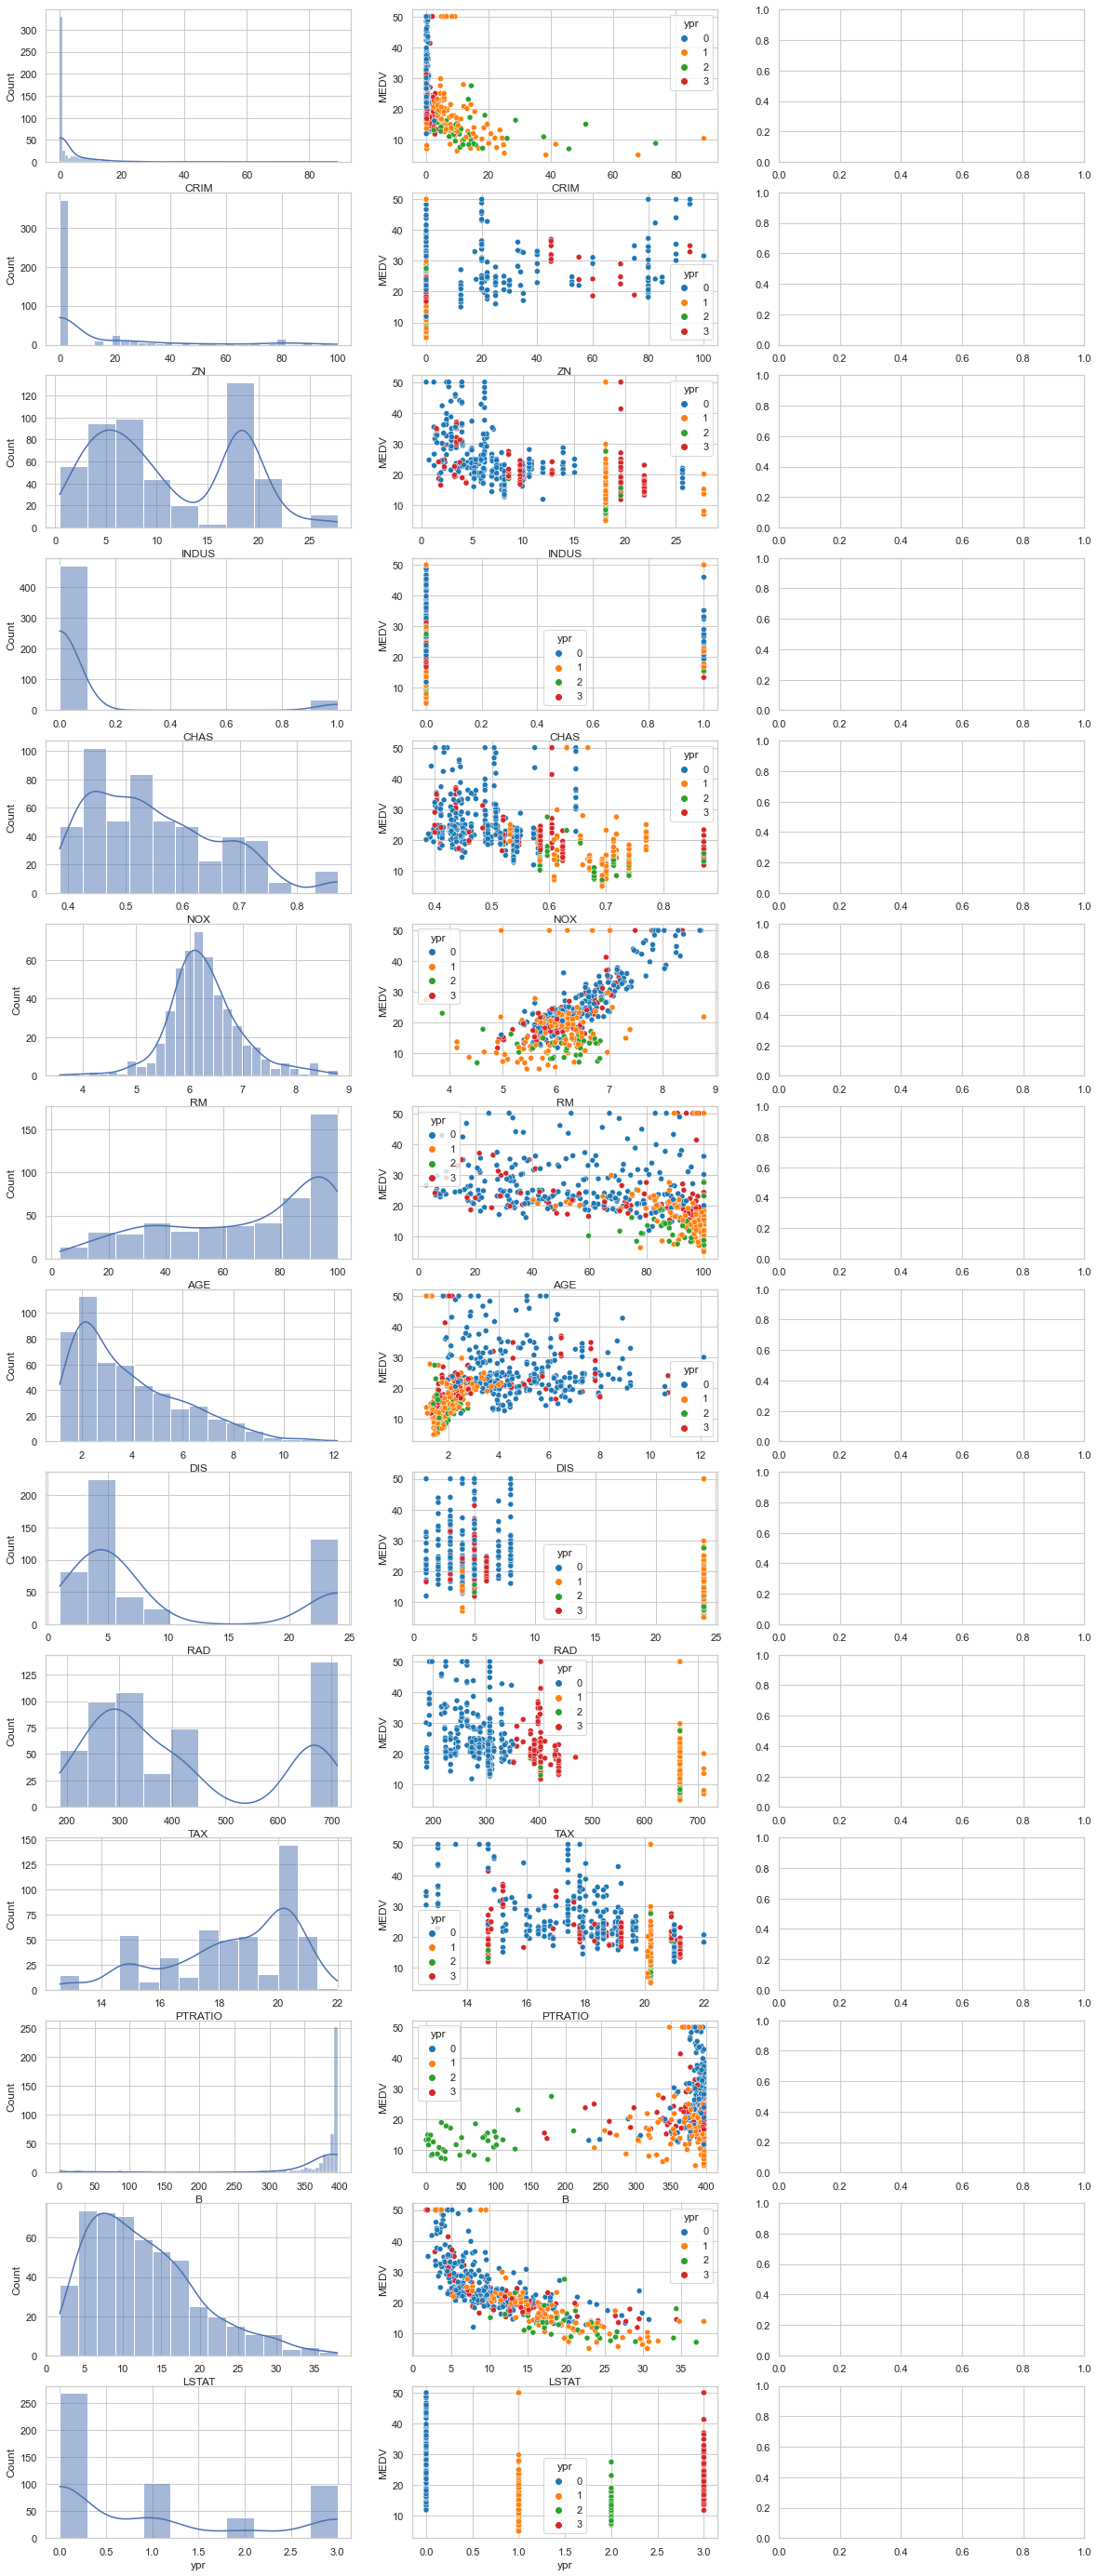

In [37]:
#visualizing and transforming features against dependent variable
fig,ax = plt.subplots(nrows=(len(col)-1),ncols=3,figsize=(20,50));
for i in range (1,len(col),1):
    sns.histplot(data=df_cluster.iloc[:,i],kde=True,ax=ax[i-1,0])
    sns.scatterplot(data=df_cluster,x=col[i],y=col[0],ax=ax[i-1,1],hue='ypr',palette='tab10');


In [38]:
# I will separate the data into 2 clusters, regenerate a linear regression model and check the score again

#modeling with 2 clusters
df = df_rw.copy()
df = df[['MEDV','CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT']]
df_tr,df_ts = train_test_split(df,train_size=0.95,shuffle=True)

model_cluster = KMeans(n_clusters=2,init='k-means++')
cluster_no_tr = model_cluster.fit_predict(df_tr)
df_tr['cluster_no'] = cluster_no_tr

cluster_no_ts = model_cluster.predict(df_ts)
df_ts['cluster_no'] = cluster_no_ts

In [39]:
#for cluster 0
i = 0
df_tr_i=df_tr[(df_tr['cluster_no']==i)]
df_ts_i=df_ts[(df_ts['cluster_no']==i)]

ytr = df_tr_i[col[0:1]]
yts = df_ts_i[col[0:1]]

xtr = df_tr_i[col[1:]]
xts = df_ts_i[col[1:]]

m_mlinear_regression(xtr,xts,ytr,yts)

KeyError: "['ypr'] not in index"

In [ ]:
#for cluster 1
i = 1
df_tr_i=df_tr[(df_tr['cluster_no']==i)]
df_ts_i=df_ts[(df_ts['cluster_no']==i)]

ytr = df_tr_i[col[0:1]]
yts = df_ts_i[col[0:1]]

xtr = df_tr_i[col[1:]]
xts = df_ts_i[col[1:]]

m_mlinear_regression(xtr,xts,ytr,yts)

In [ ]:
#i will try to drop RAD and TAX and remodel

In [ ]:
#modeling with 2 clusters
df = df_rw.copy()
df = df[['MEDV','CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS',
       'PTRATIO', 'B', 'LSTAT']]
col = df.columns
df_tr,df_ts = train_test_split(df,train_size=0.95,shuffle=True)

model_cluster = KMeans(n_clusters=2,init='k-means++')
cluster_no_tr = model_cluster.fit_predict(df_tr)
df_tr['cluster_no'] = cluster_no_tr

cluster_no_ts = model_cluster.predict(df_ts)
df_ts['cluster_no'] = cluster_no_ts

In [ ]:
#for cluster 0
i = 0
df_tr_i=df_tr[(df_tr['cluster_no']==i)]
df_ts_i=df_ts[(df_ts['cluster_no']==i)]

ytr = df_tr_i[col[0:1]]
yts = df_ts_i[col[0:1]]

xtr = df_tr_i[col[1:]]
xts = df_ts_i[col[1:]]

m_mlinear_regression(xtr,xts,ytr,yts)

In [ ]:
#for cluster 1
i = 1
df_tr_i=df_tr[(df_tr['cluster_no']==i)]
df_ts_i=df_ts[(df_ts['cluster_no']==i)]

ytr = df_tr_i[col[0:1]]
yts = df_ts_i[col[0:1]]

xtr = df_tr_i[col[1:]]
xts = df_ts_i[col[1:]]

m_mlinear_regression(xtr,xts,ytr,yts)

In [ ]:
# I will separate the data into 4 clusters, regenerate a linear regression model and check the score again

#modeling with 4 clusters
df = df_rw.copy()
df = df[['MEDV','CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT']]
df_tr,df_ts = train_test_split(df,train_size=0.95,shuffle=True)

model_cluster = KMeans(n_clusters=4,init='k-means++')
cluster_no_tr = model_cluster.fit_predict(df_tr)
df_tr['cluster_no'] = cluster_no_tr

cluster_no_ts = model_cluster.predict(df_ts)
df_ts['cluster_no'] = cluster_no_ts

In [ ]:
#for cluster 0
i = 0
df_tr_i=df_tr[(df_tr['cluster_no']==i)]
df_ts_i=df_ts[(df_ts['cluster_no']==i)]

ytr = df_tr_i[col[0:1]]
yts = df_ts_i[col[0:1]]

xtr = df_tr_i[col[1:]]
xts = df_ts_i[col[1:]]

m_mlinear_regression(xtr,xts,ytr,yts)

In [ ]:
#for cluster 1
i = 1
df_tr_i=df_tr[(df_tr['cluster_no']==i)]
df_ts_i=df_ts[(df_ts['cluster_no']==i)]

ytr = df_tr_i[col[0:1]]
yts = df_ts_i[col[0:1]]

xtr = df_tr_i[col[1:]]
xts = df_ts_i[col[1:]]

m_mlinear_regression(xtr,xts,ytr,yts)

In [ ]:
#for cluster 2
i = 2
df_tr_i=df_tr[(df_tr['cluster_no']==i)]
df_ts_i=df_ts[(df_ts['cluster_no']==i)]

ytr = df_tr_i[col[0:1]]
yts = df_ts_i[col[0:1]]

xtr = df_tr_i[col[1:]]
xts = df_ts_i[col[1:]]

m_mlinear_regression(xtr,xts,ytr,yts)

In [ ]:
#for cluster 3
i = 3
df_tr_i=df_tr[(df_tr['cluster_no']==i)]
df_ts_i=df_ts[(df_ts['cluster_no']==i)]

ytr = df_tr_i[col[0:1]]
yts = df_ts_i[col[0:1]]

xtr = df_tr_i[col[1:]]
xts = df_ts_i[col[1:]]

m_mlinear_regression(xtr,xts,ytr,yts)

# To Do

- k fold and  and add dimensional reduction to main regression code
- read and check models evaluations- 
- generalize a code for clustering